In [43]:
import pandas as pd
import pyreadr

# Load high school data from two sources and merge them
hs_df_old = pyreadr.read_r("../data/raw/HS 23-24 Responses.Rdata")["responses"]
hs_df_new = pyreadr.read_r("../data/raw/HS 23-24 Responses New.Rdata")["responses_HS"]

# Concatenate the two high school dataframes
hs_df = pd.concat([hs_df_old, hs_df_new], ignore_index=True)

In [34]:
# Load college data
college_df = pyreadr.read_r("../data/raw/College 24 Responses v5.3.Rdata")[
    "responses5.3"
]

In [35]:
# keep the book version consistnet
# be careful, need to use regex=False
BOOK_VERSION_INDICATOR = "(ABC)"

In [44]:
set(hs_df["release"])

{'release/v4.1',
 'release/v5.0',
 'release/v5.1',
 'release/v5.1.1',
 'release/v5.2',
 'v5.2',
 'v5.3',
 'v5.4',
 'v5.5',
 'v5.5.1'}

In [ ]:
import pandas as pd

pd.set_option("display.max_colwidth", None)

hs_df[["release", "book"]].groupby("release")["book"].agg(list).apply(set)

release
release/v4.1                                                                    {College / Statistics and Data Science (ABC), High School / Advanced Statistics and Data Science I (ABC), High School / Statistics and Data Science I (AB)}
release/v5.0                                                          {College / Advanced Statistics and Data Science (ABCD), High School / Advanced Statistics and Data Science I (ABC), High School / Statistics and Data Science I (AB)}
release/v5.1                                                                                                                                                                             {High School / Statistics and Data Science I (AB)}
release/v5.1.1                                                                                                                                                                           {High School / Statistics and Data Science I (AB)}
release/v5.2                                    

In [46]:
# process hs data
hs_df = hs_df[
    hs_df["release"].isin(
        [
            "release/v5.0",
            "release/v5.1",
            "release/v5.1.1",
            "release/v5.2",
            "v5.2",
            "v5.3",
        ]
    )
]
hs_df = hs_df[hs_df["book"].str.contains(BOOK_VERSION_INDICATOR, regex=False)]
len(hs_df)

576156

In [47]:
set(hs_df["release"])

{'release/v5.0', 'release/v5.2', 'v5.2', 'v5.3'}

In [49]:
# process college data
college_df = college_df[
    college_df["book"].str.contains(BOOK_VERSION_INDICATOR, regex=False)
]
len(college_df)

400437

In [50]:
import pandas as pd

# load the code book
code_book_df = pd.read_csv("../data/raw/Codebook Learning Objectives.csv")

In [ ]:
# Check the unique common item ids between repsonse and code book
print("HS: ", len(set(code_book_df.item_id) & set(hs_df.item_id)))
print("College: ", len(set(code_book_df.item_id) & set(college_df.item_id)))
print(
    "HS & College: ",
    len(
        (set(code_book_df.item_id) & set(hs_df.item_id))
        & (set(code_book_df.item_id) & set(college_df.item_id))
    ),
)

HS:  787
College:  786
HS & College:  786


In [52]:
# filter out rows whose points_possible is nan
hs_df = hs_df.dropna(subset=["points_possible"])
college_df = college_df.dropna(subset=["points_possible"])

# Convert points_possible to int for consistent comparison
# the type was inferred as string for some response tables
hs_df["points_possible"] = hs_df["points_possible"].astype(int)
college_df["points_possible"] = college_df["points_possible"].astype(int)

# Filter rows where points_possible is 1
hs_df = hs_df[hs_df["points_possible"] == 1]
college_df = college_df[college_df["points_possible"] == 1]

In [53]:
# check again
# Check the unique common item ids between repsonse and code book
print("HS: ", len(set(code_book_df.item_id) & set(hs_df.item_id)))
print("College: ", len(set(code_book_df.item_id) & set(college_df.item_id)))
print(
    "HS & College: ",
    len(
        (set(code_book_df.item_id) & set(hs_df.item_id))
        & (set(code_book_df.item_id) & set(college_df.item_id))
    ),
)

# diff between hs and college
print(
    "HS - College: ",
    (set(code_book_df.item_id) & set(hs_df.item_id))
    - (set(code_book_df.item_id) & set(college_df.item_id)),
)

HS:  700
College:  698
HS & College:  698
HS - College:  {'b2_Sum_11', 'B4_Shuffle_01'}


In [54]:
# Do the actual filtering based on id_p, which is the concategation of item_id and lrn_question_position

# Setup a new column called id_p
hs_df["id_p"] = (
    hs_df["item_id"].astype(str) + " " + hs_df["lrn_question_position"].astype(str)
)
college_df["id_p"] = (
    college_df["item_id"].astype(str)
    + " "
    + college_df["lrn_question_position"].astype(str)
)

# filter the response based on id_p
hs_df = hs_df[hs_df["id_p"].isin(set(code_book_df["id_p"]))]
college_df = college_df[college_df["id_p"].isin(set(code_book_df["id_p"]))]

In [55]:
# number of unique questions with possible points = 1
print(len(set(hs_df["id_p"])))
print(len(set(college_df["id_p"])))

547
546


In [56]:
# get common questions
unique_questions = set(hs_df["id_p"]) & set(college_df["id_p"])
len(unique_questions)

546

In [57]:
# Only keep the common questions from the responses
hs_df = hs_df[hs_df["id_p"].isin(unique_questions)]
college_df = college_df[college_df["id_p"].isin(unique_questions)]

In [58]:
print(len(hs_df))
print(len(college_df))

231380
157429


In [59]:
# dump the intermediate data
hs_df.to_csv("hs_df_v5_0-v5_3_assessment_questions.csv", index=False)
college_df.to_csv("college_df_v5_3_assessment_questions.csv", index=False)

# Completion Rate

In [60]:
def get_student_completion_rate(df):
    """
    Calculate the completion rate of the students by:
    questions students attempted / total questions * 100.

    The output contains:
    1. a table of completion rates for each student
    2. a dictionary of completion rates for each bucket
    """
    unique_student_count = len(df["student_id"].unique())
    unique_question_count = len(df["id_p"].unique())

    questions_per_student = df.groupby("student_id")["id_p"].nunique()
    completion_rates = questions_per_student / len(unique_questions) * 100

    completion_buckets = pd.cut(
        completion_rates,
        bins=[0, 60, 70, 80, 90, 100],
        labels=["0-60", "60-70", "70-80", "80-90", "90+"],
    )
    bucket_percentages = completion_buckets.value_counts(normalize=True) * 100

    # keep two decimal places
    bucket_percentages = bucket_percentages.round(2)

    # Create result dictionary
    result = {
        "completion_rate_0-60_pct": bucket_percentages.get("0-60", 0),
        "completion_rate_60-70_pct": bucket_percentages.get("60-70", 0),
        "completion_rate_70-80_pct": bucket_percentages.get("70-80", 0),
        "completion_rate_80-90_pct": bucket_percentages.get("80-90", 0),
        "completion_rate_90+_pct": bucket_percentages.get("90+", 0),
        "unique_student_count": unique_student_count,
        "unique_question_count": unique_question_count,
    }

    return completion_rates, result

In [ ]:
import rich

hs_completion_rate, hs_completion_rate_result = get_student_completion_rate(hs_df)
college_completion_rate, college_completion_rate_result = get_student_completion_rate(
    college_df
)

rich.print(hs_completion_rate_result)
rich.print(college_completion_rate_result)

{
    'completion_rate_0-60_pct': 83.67,
    'completion_rate_60-70_pct': 4.08,
    'completion_rate_70-80_pct': 4.79,
    'completion_rate_80-90_pct': 5.84,
    'completion_rate_90+_pct': 1.62,
    'unique_student_count': 1421,
    'unique_question_count': 546
}

{
    'completion_rate_0-60_pct': 56.85,
    'completion_rate_60-70_pct': 4.81,
    'completion_rate_70-80_pct': 5.0,
    'completion_rate_80-90_pct': 14.63,
    'completion_rate_90+_pct': 18.7,
    'unique_student_count': 540,
    'unique_question_count': 546
}

In [64]:
# Plot a histogram based on hs_completion_rate

import matplotlib.pyplot as plt


def plot_completion_rate_histogram(completion_rate, title):
    plt.figure(figsize=(10, 6))
    plt.hist(completion_rate, bins=20, edgecolor="black")
    plt.xlabel("Completion Rate (%)")
    plt.ylabel("Number of Students")
    plt.title(f"Distribution of Student Completion Rates ({title})")
    plt.grid(True)
    plt.show()

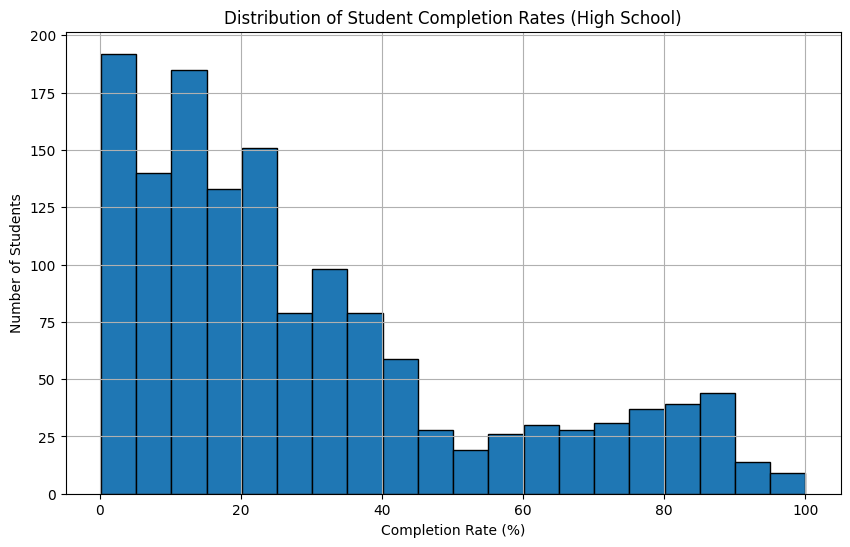

In [65]:
plot_completion_rate_histogram(hs_completion_rate, "High School")

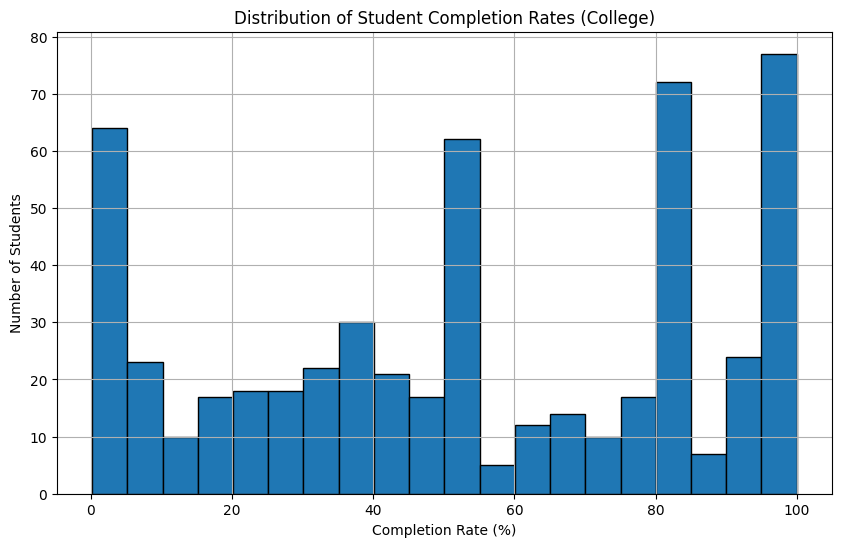

In [75]:
plot_completion_rate_histogram(college_completion_rate, "College")

In [67]:
# We will use 80% as the cutoff for the completion rate
THRESHOLD = 80
hs_valid_student_ids = set(hs_completion_rate[hs_completion_rate > THRESHOLD].index)
college_valid_student_ids = set(
    college_completion_rate[college_completion_rate > THRESHOLD].index
)

In [ ]:
hs_df = hs_df[hs_df["student_id"].isin(hs_valid_student_ids)]
college_df = college_df[college_df["student_id"].isin(college_valid_student_ids)]

print(len(hs_df))
print(len(college_df))

50250
88955


# Max score

In [69]:
def get_student_max_scores(df):
    """
    Generate a table where each row is a student and each column is a question. The value is the max score for the corresponding question.
    """
    # Get unique questions from the dataframe
    unique_questions = df["id_p"].unique()

    # Group by student_id and id_p to get max points for each student-question pair
    max_scores = df.groupby(["student_id", "id_p"])["points_earned"].max().reset_index()

    # Pivot the table to get questions as columns and students as rows
    student_scores = max_scores.pivot(
        index="student_id", columns="id_p", values="points_earned"
    )

    # Add missing question columns with NULL values
    missing_questions = set(unique_questions) - set(student_scores.columns)
    for q in missing_questions:
        student_scores[q] = None

    return student_scores

In [70]:
hs_student_performance = get_student_max_scores(hs_df)
college_student_performance = get_student_max_scores(college_df)

In [71]:
# save the student performance
hs_student_performance.to_csv("hs_student_performance.csv", index=False)
college_student_performance.to_csv("college_student_performance.csv", index=False)

In [72]:
# Compute the mean score across questions for each student

# Convert string values to numeric before calculating mean
hs_student_performance = hs_student_performance.apply(pd.to_numeric, errors="coerce")
college_student_performance = college_student_performance.apply(
    pd.to_numeric, errors="coerce"
)

# Now calculate the mean
hs_student_performance_avg = hs_student_performance.mean(axis=1, skipna=True)
college_student_performance_avg = college_student_performance.mean(axis=1, skipna=True)

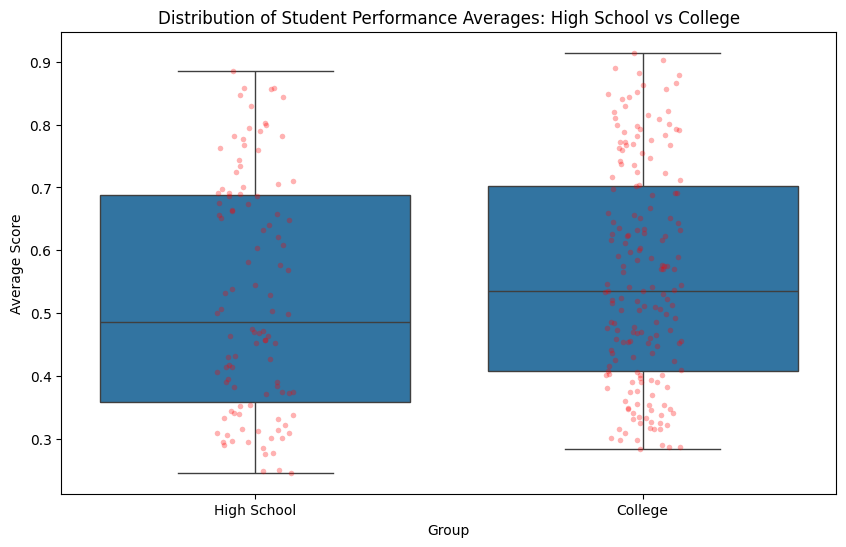

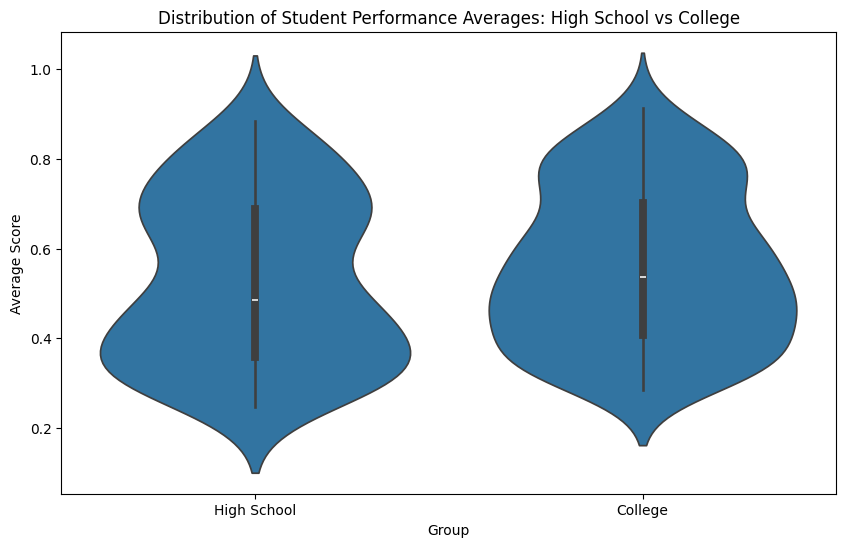

In [ ]:
# Create a DataFrame for plotting
import seaborn as sns
from matplotlib import pyplot as plt

plot_data = pd.DataFrame(
    {
        "Average Score": pd.concat(
            [hs_student_performance_avg, college_student_performance_avg]
        ),
        "Group": ["High School"] * len(hs_student_performance_avg)
        + ["College"] * len(college_student_performance_avg),
    }
)

# Create the distribution plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=plot_data, x="Group", y="Average Score")
sns.stripplot(
    data=plot_data, x="Group", y="Average Score", color="red", alpha=0.3, size=4
)

plt.title("Distribution of Student Performance Averages: High School vs College")
plt.ylabel("Average Score")
plt.show()

# Also create a violin plot for better visualization of the distribution
plt.figure(figsize=(10, 6))
sns.violinplot(data=plot_data, x="Group", y="Average Score")
plt.title("Distribution of Student Performance Averages: High School vs College")
plt.ylabel("Average Score")
plt.show()

In [74]:
# Perform independent t-test to compare HS vs College performance
from scipy import stats

t_stat, p_value = stats.ttest_ind(
    hs_student_performance_avg.dropna(), college_student_performance_avg.dropna()
)

print("\nIndependent t-test results:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Print mean scores for each group
print("\nMean scores:")
print(f"High School: {hs_student_performance_avg.mean():.4f}")
print(f"College: {college_student_performance_avg.mean():.4f}")


Independent t-test results:
t-statistic: -1.4408
p-value: 0.1507

Mean scores:
High School: 0.5267
College: 0.5581
